In [1]:
# learning code from https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/Users/LuQiang/Downloads/creditcard.csv')

In [3]:

df.shape


(284807, 31)

In [4]:
df.isnull().values.any()

False

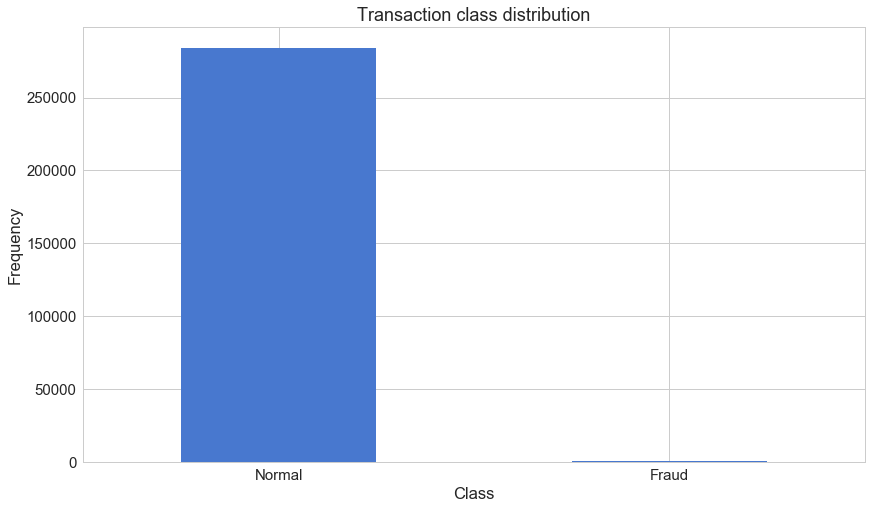

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [6]:
print (df.columns)
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


(492, 31)

In [7]:
normal.shape


(284315, 31)

In [8]:
frauds.Amount.describe()


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

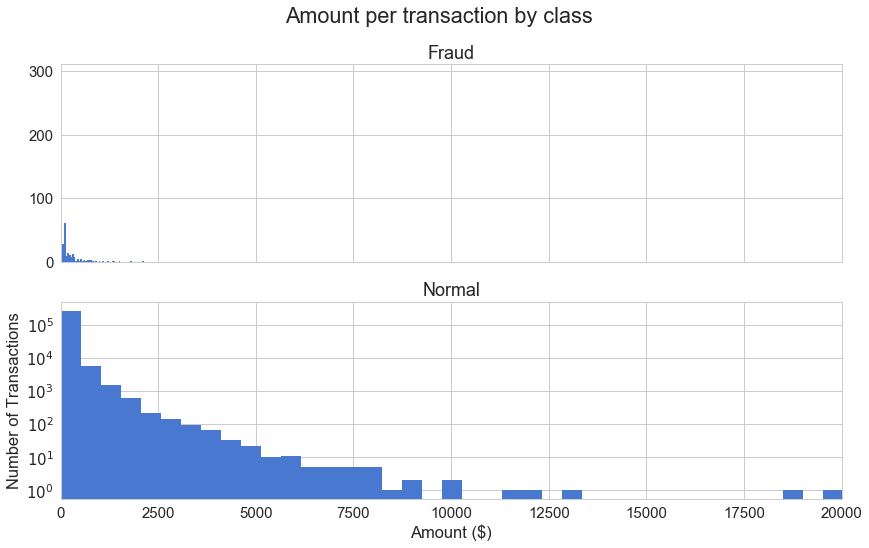

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

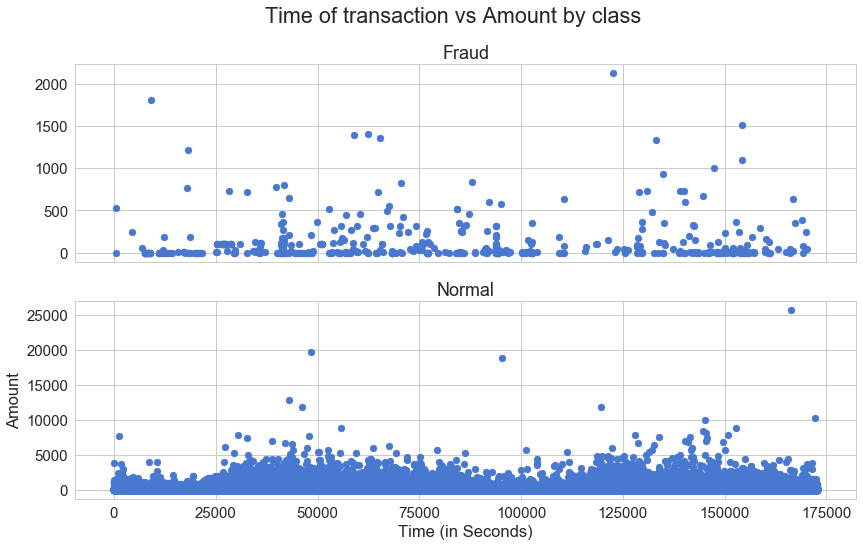

In [11]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

# use normal transactions as training

In [134]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'],axis=1)
# TODO should we only have X_test whose 'Class' equals 0?

X_test_for_training = X_test[X_test.Class == 0].drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)


X_train = X_train.values
X_test_for_training = X_test_for_training.values

X_train.shape

(227451, 29)

In [135]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)

decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(input=input_layer, output=decoder)

In [120]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                              verbose=0,
                            save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                         nb_epoch=nb_epoch,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(X_test_for_training, X_test_for_training),
                         verbose=1,
                         callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56864 samples
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
227451/227451 [==============================] - 31s - loss: 0.8254 - acc: 0.5884 - val_loss: 0.7499 - val_acc: 0.6391
Epoch 2/100
227451/227451 [==============================] - 31s - loss: 0.7601 - acc: 0.6469 - val_loss: 0.7309 - val_acc: 0.6523
Epoch 3/100
227451/227451 [==============================] - 30s - loss: 0.7496 - acc: 0.6532 - val_loss: 0.7260 - val_acc: 0.6537
Epoch 4/100
227451/227451 [==============================] - 30s - loss: 0.7446 - acc: 0.6548 - val_loss: 0.7217 - val_acc: 0.6577
Epoch 5/100
227451/227451 [==============================] - 30s - loss: 0.7385 - acc: 0.6552 - val_loss: 0.7163 - val_acc: 0.6591
Epoch 6/100
227451/227451 [==============================] - 31s - loss: 0.7345 - acc: 0.6571 - val_loss: 0.7142 - val_acc: 0.6570
Epoch 7/100
227451/227451 [==============================] - 31s - loss: 0.7323 - acc: 0.6579 - v

In [121]:
autoencoder = load_model('model.h5')

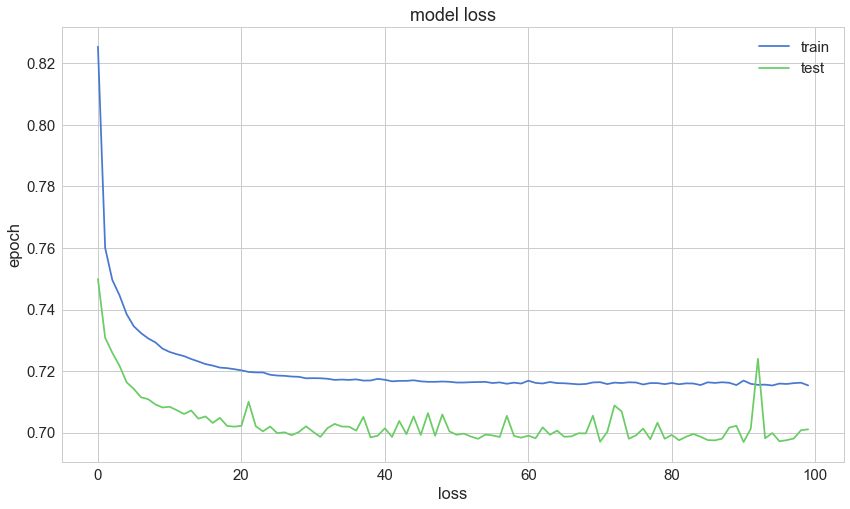

In [122]:
"""Evaluation"""
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [143]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

IndexError: indices are out-of-bounds

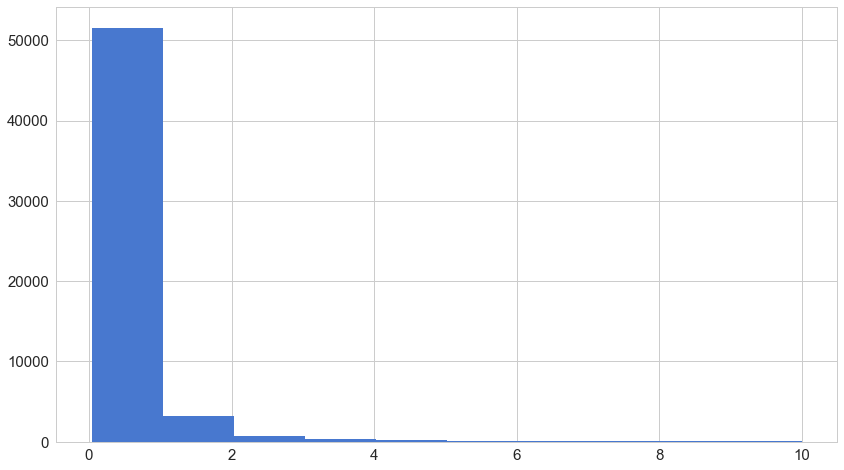

In [125]:
"""Reconstruction error without fraud"""

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

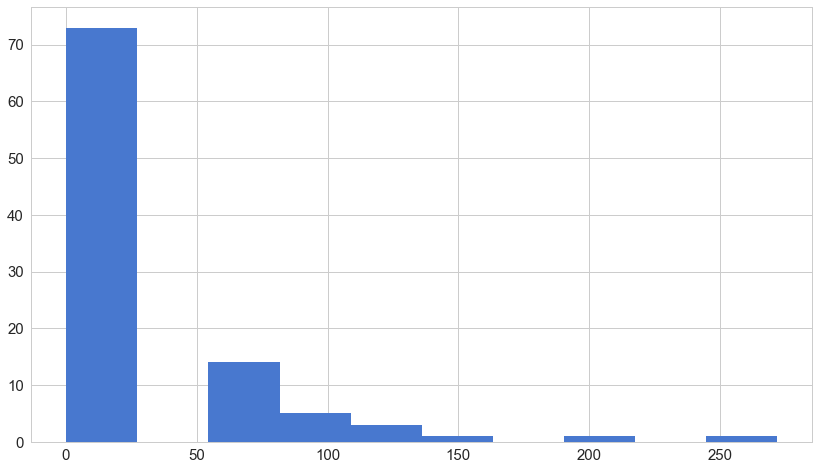

In [126]:
"""Reconstruction error with fraud"""
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [127]:
"""ROC curve"""
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve,
                             recall_score, classification_report, f1_score, precision_recall_fscore_support)


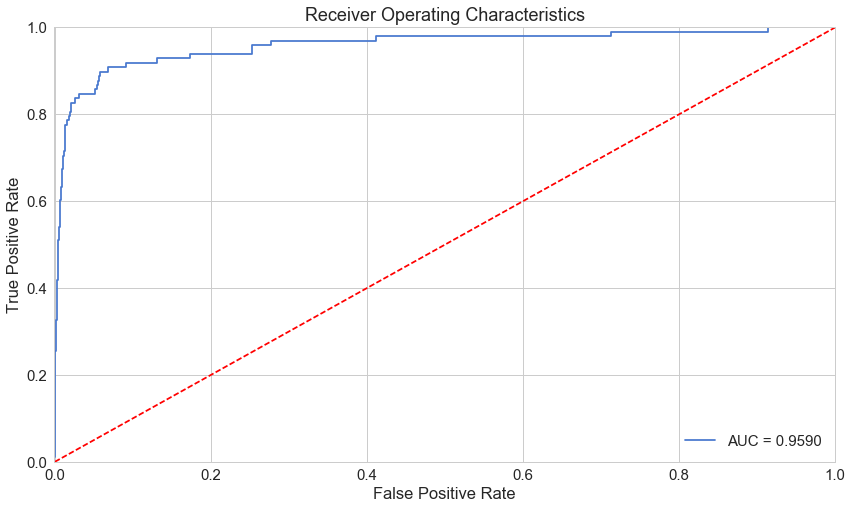

In [128]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# our data is very imbalanced, thus ROC curve is not useful here

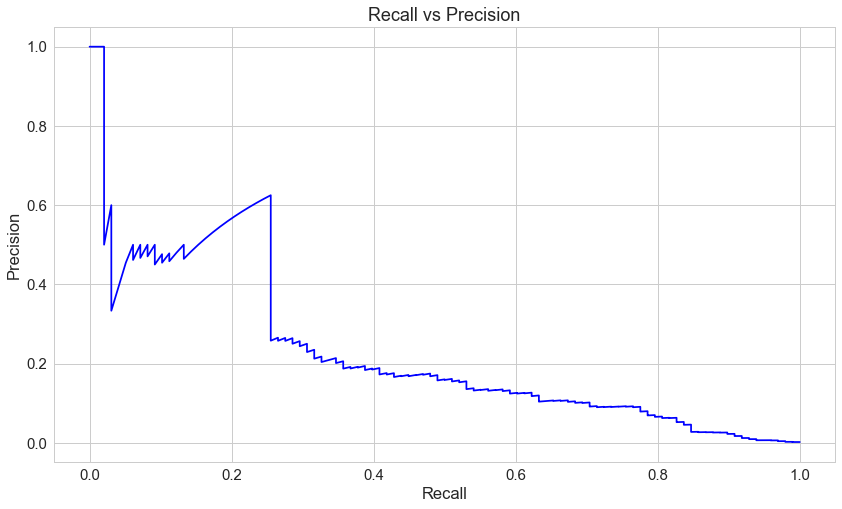

In [129]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

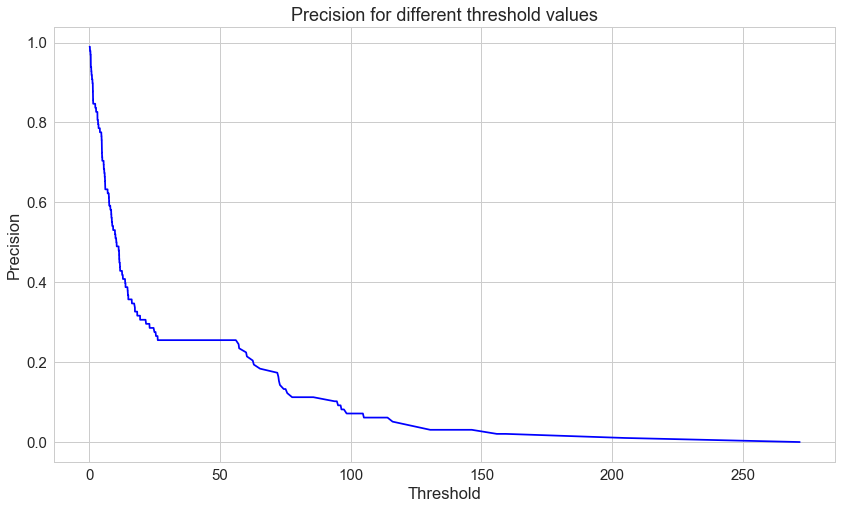

In [130]:
plt.plot(th, recall[1:], 'b', label='Threshold-Precision Curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [131]:
threshold = 2.9

0
1


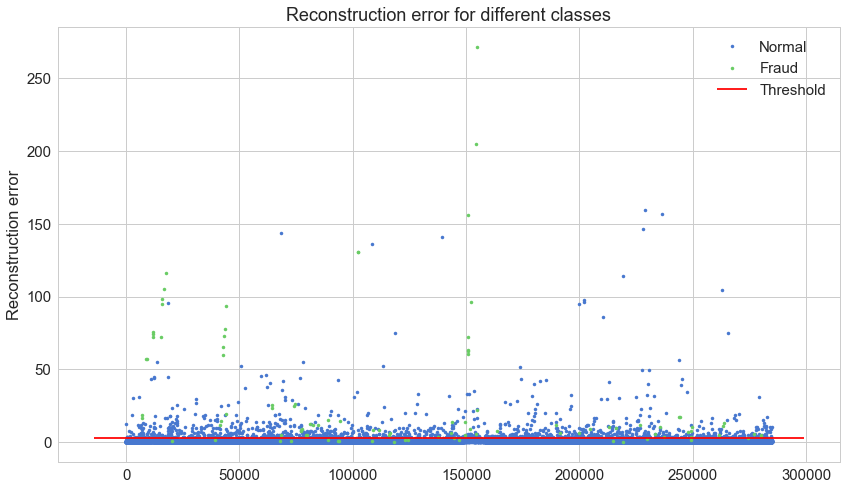

In [132]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    print (name)
    ax.plot(group.index, group.reconstruction_error, marker='o',
           ms=3.5, linestyle='', label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.show()

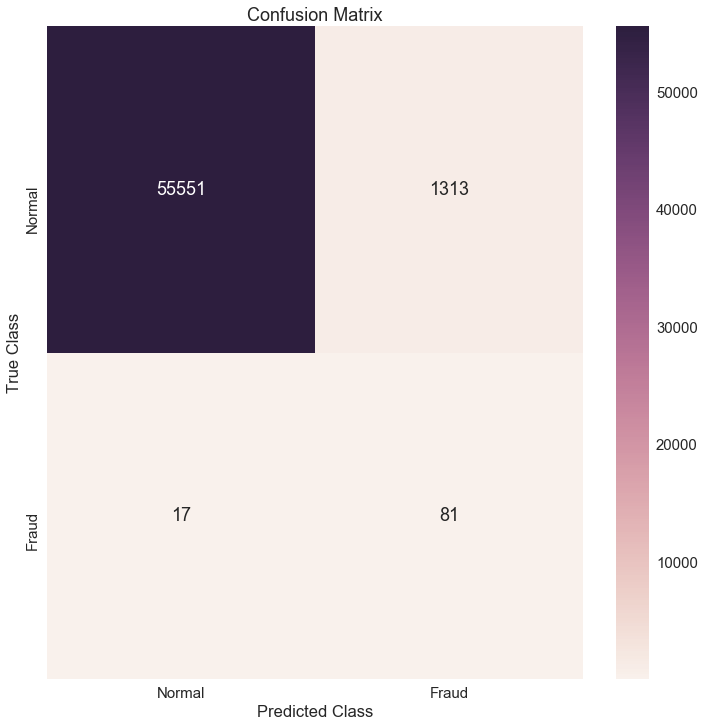

In [133]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [140]:
"""Let's try to apply autoencoder on fraud transactions"""
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class==1]
X_train = X_train.drop(['Class'],axis=1)
print (len(X_train))

X_test_for_training = X_test[X_test.Class == 1].drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)


X_train = X_train.values
X_test_for_training = X_test_for_training.values

X_train.shape

394


(394, 29)

In [141]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)

decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(input=input_layer, output=decoder)

In [142]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                              verbose=0,
                            save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                         nb_epoch=nb_epoch,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(X_test_for_training, X_test_for_training),
                         verbose=1,
                         callbacks=[checkpointer, tensorboard]).history

Train on 394 samples, validate on 98 samples
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
394/394 [==============================] - 0s - loss: 26.4476 - acc: 0.1091 - val_loss: 31.7678 - val_acc: 0.1837
Epoch 2/100
394/394 [==============================] - 0s - loss: 26.2544 - acc: 0.2310 - val_loss: 31.6396 - val_acc: 0.2551
Epoch 3/100
394/394 [==============================] - 0s - loss: 26.1588 - acc: 0.2107 - val_loss: 31.5141 - val_acc: 0.1837
Epoch 4/100
394/394 [==============================] - 0s - loss: 26.0127 - acc: 0.2030 - val_loss: 31.3104 - val_acc: 0.2551
Epoch 5/100
394/394 [==============================] - 0s - loss: 25.8060 - acc: 0.2411 - val_loss: 31.0893 - val_acc: 0.2755
Epoch 6/100
394/394 [==============================] - 0s - loss: 25.5608 - acc: 0.2208 - val_loss: 30.8620 - val_acc: 0.1735
Epoch 7/100
394/394 [==============================] - 0s - loss: 25.3412 - acc: 0.2132 - val_loss: 30.6780 - val_acc: 0.2551
Epoch 8

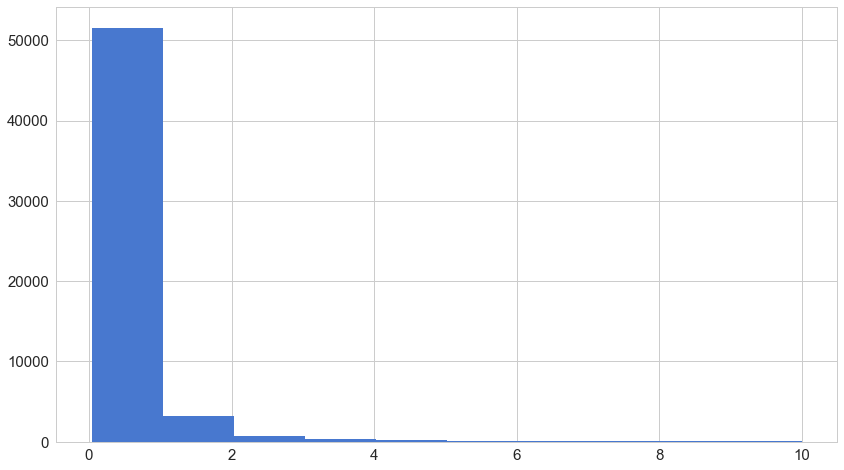

In [144]:
"""Reconstruction error without fraud"""

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)